# Binay VQE

This notebook formulates **asset selection** as a QUBO and solves it with a **Variational Quantum Eigensolver**.

### Problem

- Decision: $x_i ∈ \{0,1\}$ select asset $i$.
- Objective (mean–variance with cardinality):

  $\min_{x ∈ \{0,1\}^n}\; λ\, x^\top Σ x \;-\; μ^\top x \;+\; α\,(\mathbf{1}^\top x - K)^2$
  
  where $μ$ is expected returns, $Σ$ covariance, $K$ desired count, $λ$ risk aversion, $α$ penalty.

### Ising mapping

- Use $x_i=\tfrac{1-Z_i}{2}$. Expand to:
  
  $H = c + \sum_i h_i Z_i + \sum_{i<j} J_{ij} Z_i Z_j$

  with coefficients from the expanded QUBO. VQE minimizes $⟨ H ⟩$.

### Ansatz

- Hardware-efficient $R_Y$ layers with $C_Z$ ring entanglement and depth $d$.  
- Parameters $θ ∈ \mathbb{R}^{d × n}$.

### Optimization

- Cost: $E(θ) = ⟨H⟩$.  
- Optimizer: Adam with autograd and analytic gradients (parameter-shift).  
- Device: `default.qubit`, `shots=None` for exact expectations during training.

### Outputs

- **Convergence curve**: energy vs iteration.  
- **Inclusion probabilities**: $p_i = \tfrac{1-⟨Z_i⟩}{2}$.  
- **Sampled bitstrings**: histogram in Dirac notation $|b_1 … b_n⟩$.  
- **Candidate portfolios**: rounded vector, top-K projection, and sample-mode, with objective values.

### Validation

- Check $\sum_i x_i$ vs $K$ and increase $α$ if violated.  
- Compare to **brute-force** (for small $n$) or a **classical QUBO solver** for ground truth.

### Reproducibility

- Fix seeds for parameters and sampling.  
- Record $(λ, α, K, d, \text{steps})$ with results.

### Notes

- Larger $d$ and entanglers can improve expressivity but slow optimization.  
- For deployment, use finite `shots` and re-evaluate energies to estimate sampling variance.

#### Normalization and comparability

- Binary VQE solves a **selection** problem. Vectors are binary ($x ∈ \{0,1\}$) or **marginal inclusion probabilities** $p_i = (1-⟨Z_i⟩)/2$. These do **not** sum to 1 by design, because the constraint is $\sum x_i = K$, not a budget split.
- For **comparisons** with fractional methods (Markowitz, Fractional VQE), we also show **normalized views**:
  - **Probabilities → allocations:** $w_i = p_i / \sum_j p_j$ (interpretable as fractional exposure implied by the quantum model).
  - **Top-K selections → equal-weight portfolio:** after projecting to K assets, set $w_i = 1/K$ on selected names.
- Efficient frontiers are reported in **natural units** (return, σ). We keep the frontier **unnormalized** to preserve real magnitudes. Normalizing both axes adds no insight and only rescales the plot.
- Readouts therefore appear in two forms:
  - **Raw (selection view):** probabilities, bitstrings, Top-K binary vectors.
  - **Normalized (allocation view):** probability bars and λ-sweep bars scaled to sum to 1; frontier computed from equal-weight Top-K.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pennylane import draw_mpl
import os
os.makedirs("images", exist_ok=True)

np.random.seed(0)

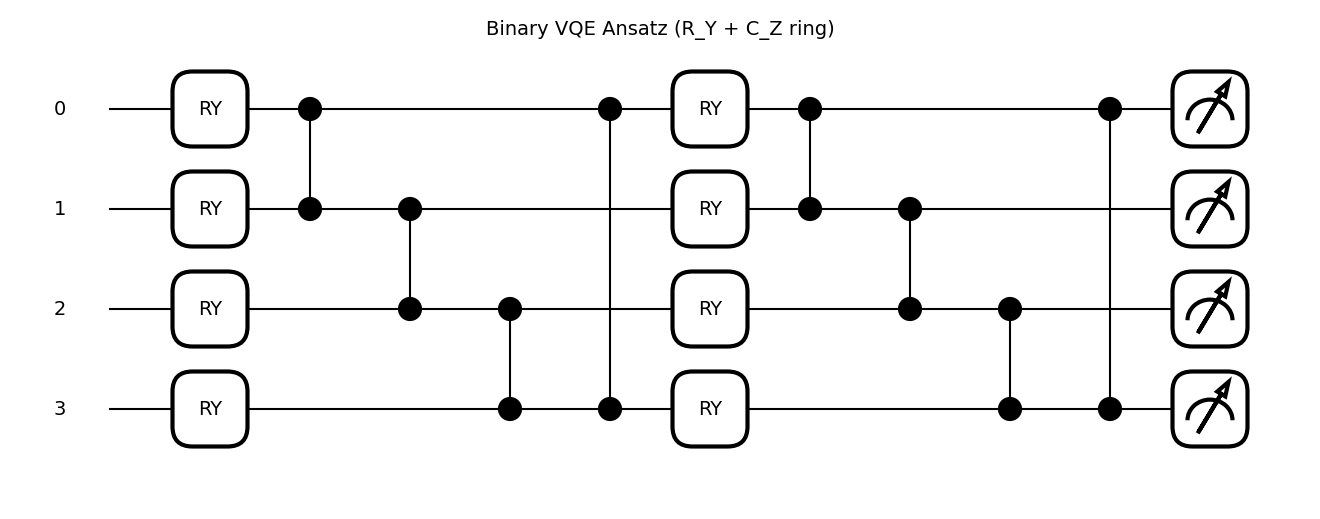

In [2]:
# Expected returns
mu = np.array([0.10, 0.20, 0.15, 0.12], requires_grad=False)

# Covariance matrix
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
], requires_grad=False)

n = len(mu)
lam = 5.0    # Risk aversion for selection
K = 2        # Select exactly K assets
alpha = 2.0  # Penalty strength

# Build Ising Hamiltonian
def build_ising(mu, Sigma, lam, alpha, K):
    """
    Build Ising Hamiltonian for:
        f(x) = lam x^T Sigma x - mu^T x + alpha (sum x - K)^2
    using x_i = (1 - Z_i)/2.
    """
    n = len(mu)
    mu = np.array(mu, requires_grad=False)
    Sigma = np.array(Sigma, requires_grad=False)

    # Defensive symmetrization
    Sigma = 0.5 * (Sigma + Sigma.T)

    # ----- QUBO coefficients -----
    # Constant term
    const = float(alpha * K**2)

    # Linear terms a_i x_i
    a = lam * np.diag(Sigma) - mu + alpha * (1 - 2 * K)

    # Pairwise terms b_ij x_i x_j  (i<j only)
    b = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            b[i, j] = 2 * lam * Sigma[i, j] + 2 * alpha

    # ----- QUBO → Ising -----
    c = const
    h = np.zeros(n)
    J = np.zeros((n, n))

    # Linear
    for i in range(n):
        c += 0.5 * a[i]
        h[i] += -0.5 * a[i]

    # Pairwise
    for i in range(n):
        for j in range(i + 1, n):
            bij = b[i, j]
            c += 0.25 * bij
            h[i] += -0.25 * bij
            h[j] += -0.25 * bij
            J[i, j] += 0.25 * bij

    # Build Hamiltonian
    coeffs = [float(c)]
    ops = [qml.Identity(0)]

    for i in range(n):
        if abs(h[i]) > 1e-12:
            coeffs.append(float(h[i]))
            ops.append(qml.PauliZ(i))

    for i in range(n):
        for j in range(i + 1, n):
            if abs(J[i, j]) > 1e-12:
                coeffs.append(float(J[i, j]))
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)

H = build_ising(mu, Sigma, lam, alpha, K)

# Ansatz and cost
depth = 2
dev = qml.device("default.qubit", wires=n, shots=None)

def ansatz(params):
    # Hardware-efficient layers: R_Y + C_Z ring
    for d in range(depth):
        for i in range(n):
            qml.RY(params[d, i], wires=i)
        for i in range(n-1):
            qml.CZ(wires=[i, i+1])
        if n > 2:
            qml.CZ(wires=[n-1, 0])

@qml.qnode(dev, interface="autograd")
def energy(params):
    ansatz(params)
    return qml.expval(H)

# Circuit preview QNode
@qml.qnode(dev, interface="autograd")
def circuit_preview(p):
    ansatz(p)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

# Use a simple pattern of angles just for drawing
demo_params = np.tile(np.linspace(0, np.pi/2, n), (depth, 1))
fig, ax = draw_mpl(circuit_preview)(demo_params)
fig.suptitle("Binary VQE Ansatz (R_Y + C_Z ring)", fontsize=14)
plt.savefig("images/Binary_VQE_Circuit.png", dpi=300, bbox_inches="tight")
plt.show()

In [3]:
# Optimize
params = np.array(np.random.uniform(0, np.pi, size=(depth, n)), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.3)
steps = 75
history = []

for t in range(steps):
    params, e = opt.step_and_cost(energy, params)
    if (t+1) % 5 == 0:
        history.append(float(e))
        print(f"step {t+1:03d}  energy={float(e):.6f}")

step 005  energy=0.845885
step 010  energy=0.422433
step 015  energy=0.143896
step 020  energy=0.189269
step 025  energy=0.064153
step 030  energy=0.059135
step 035  energy=0.024043
step 040  energy=0.023336
step 045  energy=0.015216
step 050  energy=0.015137
step 055  energy=0.011669
step 060  energy=0.009757
step 065  energy=0.009003
step 070  energy=0.008311
step 075  energy=0.007965


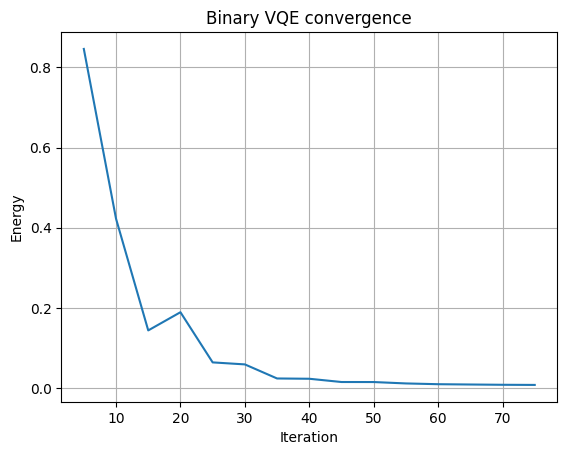

In [4]:
# Convergence plot
plt.figure()
plt.plot(range(5, steps+1, 5), history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Binary VQE convergence")
plt.grid(True)
plt.savefig("images/Binary_VQE_Convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
# Inspect expected bits and sample a binary portfolio
@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def exp_Z(params):
    ansatz(params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

z = np.stack(exp_Z(params))
x_expect = (1 - z) * 0.5                 # in [0,1]
x_round = (x_expect >= 0.5).astype(int)  # naive rounding

print("Expected x:", x_expect.round(3))
print("Rounded x :", x_round.tolist(), " sum=", int(x_round.sum()))

Expected x: [0.001 1.    0.043 0.957]
Rounded x : [0, 1, 0, 1]  sum= 2


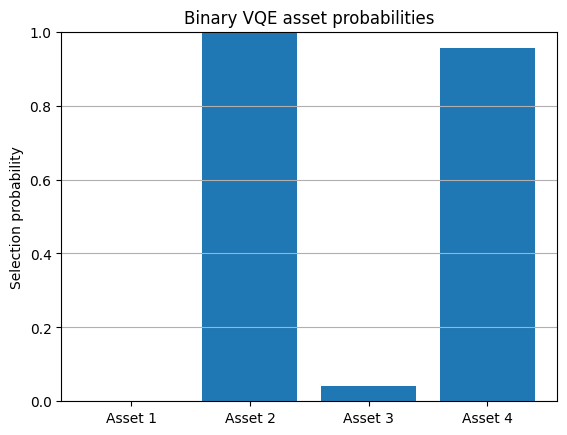

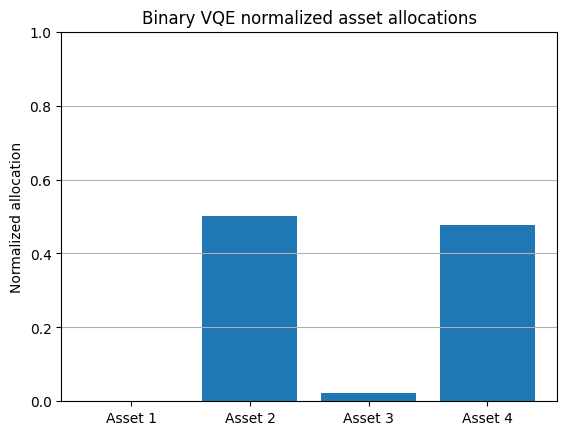

In [6]:
# Bar plot
x_probs = x_expect  # (1−⟨Z⟩)/2 values already in [0,1]
plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n)], x_probs)
plt.ylabel("Selection probability")
plt.ylim(0, 1)
plt.title("Binary VQE asset probabilities")
plt.grid(axis="y")
plt.savefig("images/Binary_VQE_Probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

# Normalized version: scale so bars sum to 1
x_probs_norm = x_probs / x_probs.sum()

plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n)], x_probs_norm)
plt.ylabel("Normalized allocation")
plt.ylim(0, 1)
plt.title("Binary VQE normalized asset allocations")
plt.grid(axis="y")
plt.savefig("images/Binary_VQE_Probabilities_Normalized.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
# Project to exact K by taking top-K expectations
topK = np.argsort(-x_expect)[:K]
x_topk = np.zeros(n, dtype=int); x_topk[topK] = 1
print("Top-K x    :", x_topk.tolist(), " sum=", int(x_topk.sum()))

# Sample bitstrings to get a concrete solution
shots_sampler = qml.device("default.qubit", wires=n, shots=2000)

@qml.qnode(shots_sampler)
def sample_bits(p):
    ansatz(p)
    return qml.sample(wires=range(n))

samples = sample_bits(params)

# Convert ±1 Z basis to {0,1} via computational basis measurement:
# qml.sample returns bitstrings already in {0,1}; aggregate modes:
import numpy as _np
rows = _np.array(samples)

# True mode = most frequent sampled bitstring
counts = Counter(tuple(row) for row in rows)
mode_bitstring = max(counts, key=counts.get)
x_mode = np.array(mode_bitstring, dtype=int)
print("Most-frequent bitstring x:", x_mode.tolist(), " sum=", int(x_mode.sum()))


# Simple report
def objective_value(x):
    x = _np.array(x, dtype=float)
    return float(lam * x @ Sigma @ x - mu @ x + alpha * (x.sum() - K)**2)

# Best feasible (sum=K) solution among samples
feasible = [bs for bs in counts if sum(bs) == K]
if feasible:
    x_best_feasible = min(feasible, key=lambda bs: objective_value(bs))
    x_best_feasible = np.array(x_best_feasible, dtype=int)
    print("Best-feasible sampled x:", x_best_feasible.tolist(),
          " sum=", int(x_best_feasible.sum()))
else:
    x_best_feasible = x_topk.copy()
    print("No feasible samples found; using Top-K projection.")

print("Objective(round):", objective_value(x_round))
print("Objective(topK)  :", objective_value(x_topk))
print("Objective(mode)  :", objective_value(x_mode))

Top-K x    : [0, 1, 0, 1]  sum= 2
Most-frequent bitstring x: [0, 1, 0, 1]  sum= 2
Best-feasible sampled x: [1, 1, 0, 0]  sum= 2
Objective(round): 0.009999999999999953
Objective(topK)  : 0.009999999999999953
Objective(mode)  : 0.009999999999999953


/usr/local/python/3.12.1/lib/python3.12/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


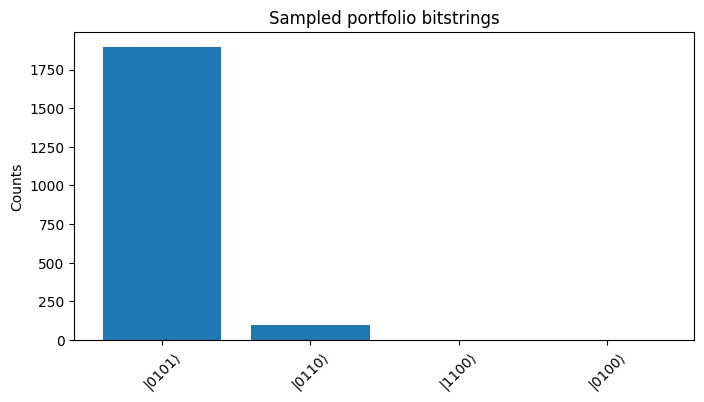

In [8]:
# Histogram of sampled binary strings
counts = Counter(tuple(row) for row in rows)
bitstrings = [''.join(map(str, bs)) for bs in counts.keys()]
frequencies = [counts[bs] for bs in counts.keys()]

# Convert to Dirac notation
labels = [f"|{b}⟩" for b in bitstrings]

plt.figure(figsize=(8,4))
plt.bar(labels, frequencies)
plt.xticks(rotation=45)
plt.ylabel("Counts")
plt.title("Sampled portfolio bitstrings")
plt.savefig("images/Binary_VQE_Portfolio_Bitstrings.png", dpi=300, bbox_inches="tight")
plt.show()

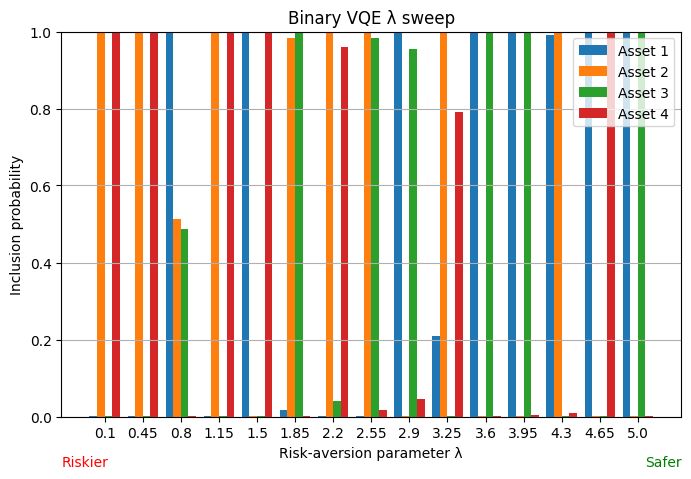

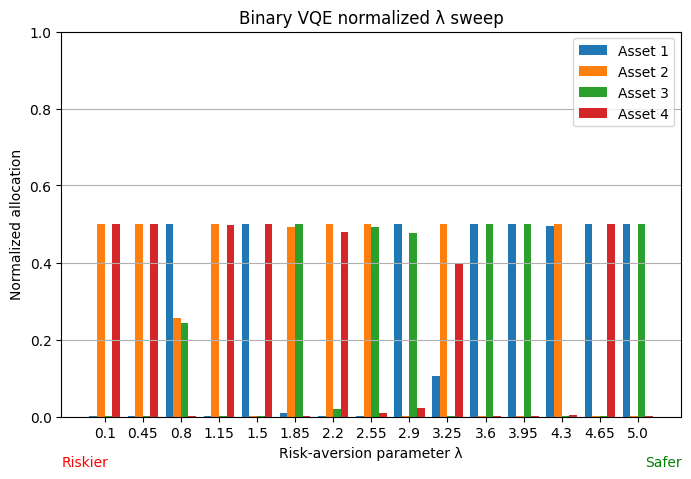

In [9]:
# λ sweep
# Vary risk aversion λ, re-optimize briefly, and plot marginal inclusion probabilities.
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)
steps_per_lam = 80
probs = []

for lam in lambdas:
    # Rebuild Hamiltonian with this λ
    H = build_ising(mu, Sigma, lam, alpha, K)

    # QNode that measures energy for current H
    @qml.qnode(dev, interface="autograd")
    def energy(params):
        ansatz(params)
        return qml.expval(H)

    # Optimize from a fresh init
    params = np.array(np.random.uniform(0, np.pi, size=(depth, n)), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.2)
    for _ in range(steps_per_lam):
        params, _ = opt.step_and_cost(energy, params)

    # Marginal inclusion probabilities x_i = (1 - <Z_i>)/2
    @qml.qnode(dev, interface="autograd")
    def exp_Z(params_):
        ansatz(params_)
        return [qml.expval(qml.PauliZ(i)) for i in range(n)]

    z = np.stack(exp_Z(params))
    x_prob = (1.0 - z) * 0.5
    probs.append(x_prob)

# Grouped bar chart
probs = np.vstack(probs)
x = np.arange(len(lambdas))
bar_width = 0.2
plt.figure(figsize=(8,5))
for i in range(n):
    plt.bar(x + i*bar_width, probs[:, i], bar_width, label=f"Asset {i+1}")

plt.xticks(x + bar_width*(n-1)/2, [f"{lam}" for lam in lambdas])
plt.ylabel("Inclusion probability")
plt.ylim(0, 1)
plt.xlabel("Risk-aversion parameter λ")
plt.title("Binary VQE λ sweep")
plt.legend()
plt.grid(axis="y")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(xmin, ymin - 0.1, "Riskier", ha="left", va="top", fontsize=10, color="red")
plt.text(xmax, ymin - 0.1, "Safer", ha="right", va="top", fontsize=10, color="green")
plt.savefig("images/Binary_VQE_Lambda_Sweep.png", dpi=200, bbox_inches="tight")


# Normalized version: enforce allocations sum to 1 at each λ
probs_norm = probs / probs.sum(axis=1, keepdims=True)
plt.figure(figsize=(8,5))
for i in range(n):
    plt.bar(x + i*bar_width, probs_norm[:, i], bar_width, label=f"Asset {i+1}")
    
plt.xticks(x + bar_width*(n-1)/2, [f"{lam}" for lam in lambdas])
plt.ylabel("Normalized allocation")
plt.ylim(0, 1)
plt.xlabel("Risk-aversion parameter λ")
plt.title("Binary VQE normalized λ sweep")
plt.legend()
plt.grid(axis="y")
plt.text(xmin, ymin - 0.1, "Riskier", ha="left", va="top", fontsize=10, color="red")
plt.text(xmax, ymin - 0.1, "Safer", ha="right", va="top", fontsize=10, color="green")
plt.savefig("images/Binary_VQE_Lambda_Sweep_Normalized.png", dpi=200, bbox_inches="tight")
plt.show()

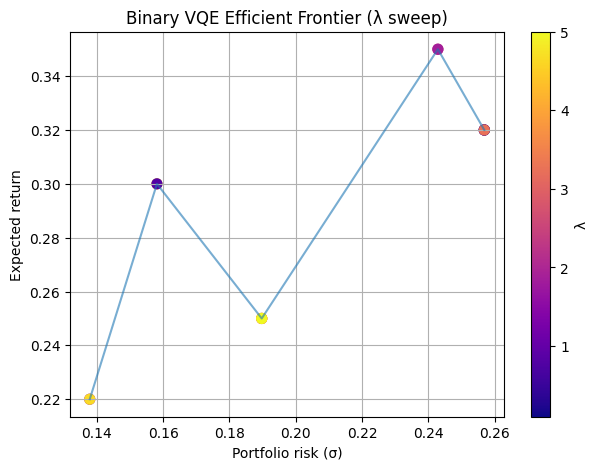

In [10]:
# Efficient frontier for Binary VQE
returns_bin = []
risks_bin = []

for x_prob in probs:
    # Project to Top-K (binary vector) to enforce selection
    topK = np.argsort(-x_prob)[:K]
    x = np.zeros(n, dtype=float); x[topK] = 1.0

    # Portfolio metrics
    R = float(mu @ x)
    sigma2 = float(x @ Sigma @ x)
    returns_bin.append(R)
    risks_bin.append(np.sqrt(sigma2))

returns_bin = np.array(returns_bin)
risks_bin = np.array(risks_bin)

# Sort by risk
order = np.argsort(risks_bin)
risks_bin = risks_bin[order]
returns_bin = returns_bin[order]
lambdas_sorted = lambdas[order]

# Plot efficient frontier
plt.figure(figsize=(7,5))
sc = plt.scatter(risks_bin, returns_bin, c=lambdas_sorted, cmap="plasma", s=50)
plt.plot(risks_bin, returns_bin, alpha=0.6)
cbar = plt.colorbar(sc)
cbar.set_label("λ")
plt.xlabel("Portfolio risk (σ)")
plt.ylabel("Expected return")
plt.title("Binary VQE Efficient Frontier (λ sweep)")
plt.grid(True)
plt.savefig("images/Binary_VQE_Efficient_Frontier.png", dpi=200, bbox_inches="tight")
plt.show()